In [1]:
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import log_loss
from scipy import optimize
import copy
import itertools
import math
from sklearn.svm import SVC
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

df_bank = pd.read_csv('../data/bank-full.csv',delimiter = ";")
compas = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')

# Data clean

In [2]:
# subset y
true_y = np.where(df_bank["y"] == "yes",1,-1)
# subset z
age = np.where((25 <= df_bank["age"]) & (df_bank["age"] <= 60),1,0)

def bankdata_process(df_bank):

    #binary variables, 1 for yes and 0 for no.
    df_bank["default"] = df_bank["default"].apply(lambda x:1 if x == "yes" else 0)
    df_bank["housing"] = df_bank["housing"].apply(lambda x:1 if x == "yes" else 0)
    df_bank["loan"] = df_bank["loan"].apply(lambda x:1 if x == "yes" else 0)
    df_bank = df_bank.drop(columns = ["age", "y", "day", "month"])

    #other variables with more than two categories, use one hot encoding
    cols = ['job', 'marital', 'education','contact','poutcome', 'campaign']
    for c in cols: 
        dummies = pd.get_dummies(df_bank[c])
        df_bank = df_bank.join(dummies, rsuffix = '_'+ c)
        df_bank = df_bank.drop(columns = [c])
    return df_bank.to_numpy()

#5-fold cross validattion, train 70%, test 30%
#train and test data
X,y,age = shuffle(bankdata_process(df_bank),true_y,age, random_state = 0)
x_train,x_test,y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)
train_index = int(len(X)*.70) 
age_train, age_test = age[:train_index],age[train_index:]


In [3]:
# Useful functions

# p-percent rule
def p_rule(attr_var, predicted_y):
  protected_indx = np.where(attr_var == 1)
  not_protected_indx = np.where(attr_var != 1)

  protected_positive = np.where(predicted_y[protected_indx] == 1)
  not_protected_positive = np.where(predicted_y[not_protected_indx] == 1)

  pro_percentage = protected_positive[0].shape[0]/protected_indx[0].shape[0]
  notpro_percentage = not_protected_positive[0].shape[0]/not_protected_indx[0].shape[0]

  p_val = pro_percentage/notpro_percentage
  return p_val, pro_percentage, notpro_percentage

def add_ones(df):
  len_df = df.shape[0]
  ones_df = np.ones(len_df).reshape(len_df, 1)
  return(np.concatenate((df, ones_df), axis = 1))

def sigmoid(t):
  return(1/(1 + np.exp(-t)))

def accuracy(params, x, y):
  h = sigmoid(np.dot(x, params.reshape(x.shape[1],1)))
  h[h>=0.5] = 1
  h[h<0.5] = -1
  correct = np.where(h == y.reshape(h.shape))
  return(correct[0].shape[0]/h.shape[0]), h


# Models

In [4]:
# LR model without constraints - Optimal coefficients
clf = LogisticRegression(random_state=0, max_iter = 500).fit(x_train, y_train)

print(f'Accuracy on training data: {clf.score(x_train, y_train)}')
print(f'P%-rule value on training data: {p_rule(age_train,clf.predict(x_train))}')
print(f'Accuracy on testing data: {clf.score(x_test, y_test)}')
print(f'P%-rule value on testing data: {p_rule(age_test,clf.predict(x_test))}')

Accuracy on training data: 0.8996745347110311
P%-rule value on training data: (0.27198505340431867, 0.05029595582156675, 0.18492176386913228)
Accuracy on testing data: 0.9016514302565615
P%-rule value on testing data: (0.2926768077094808, 0.05249364063824867, 0.1793570219966159)


In [5]:
# modify df, prepare parameters
opt_loss = log_loss(y_train, clf.predict_proba(x_train))
opt_params = np.concatenate((clf.coef_, clf.intercept_.reshape(1, 1)), axis = 1)
x_train = add_ones(x_train)
x_test = add_ones(x_test)

In [6]:
# loss function
def loss_fun(params, x, y):
  h = sigmoid(np.dot(x, params.reshape(x.shape[1],1)))
  pred_prob = np.concatenate((1-h, h), axis = 1)
  return(log_loss(y, pred_prob))

# set constrain and loss functions
def gamma_constrain(params, x, y, gamma, opt_loss):
  h = sigmoid(np.dot(x, params.reshape(x.shape[1],1)))
  pred_prob = np.concatenate((1-h, h), axis = 1)
  loss = log_loss(y, pred_prob)
  return(opt_loss*(1+gamma) - loss)

def opt_function(params, x, z):
  dist = np.dot(params, x.T)
  ind_cov = (z - np.mean(z))*dist
  return abs(sum(ind_cov) / x.shape[0])

# Make single optimization
def lr_single_constrain(x, y, z, gamma, opt_params, opt_loss):
  constraints = []
  cons = {'type': 'ineq', 'fun': gamma_constrain, 'args': (x, y, gamma, opt_loss)}
  optimizer = optimize.minimize(opt_function, x0 = opt_params, 
                             args = (x, z), method = 'SLSQP',
                             constraints = cons, options = {'maxiter': 10000})
  return(optimizer.x)

# test for our single optimizer
def eval_lr_constrain(x, y, z, params):
  accuracy_val, pred = accuracy(params, x, y)
  p_rule_val, prot_perc, nprot_perc = p_rule(z, pred)
  return accuracy_val, p_rule_val, prot_perc, nprot_perc

# multiple gamma
def lr_mult_constrain(x, y, z, x_test, y_test, z_test, opt_params, opt_loss, gamma):
  accuracy_l, p_rule_l, prot_perc_l, nprot_perc_l, loss_l = [], [], [], [], []
  accuracy_lt, p_rule_lt, prot_perc_lt, nprot_perc_lt, loss_lt = [], [], [], [], []
  for g in gamma:
    params = lr_single_constrain(x, y, z, g, opt_params, opt_loss)
    # for train eval
    acc, p, prot, nprot = eval_lr_constrain(x, y, z, params)
    los = loss_fun(params, x, y)
    accuracy_lt.append(acc)
    p_rule_lt.append(p)
    prot_perc_lt.append(prot)
    nprot_perc_lt.append(nprot)
    loss_lt.append(los)
    # for test eval
    acc, p, prot, nprot = eval_lr_constrain(x_test, y_test, z_test, params)
    los = loss_fun(params, x_test, y_test)
    accuracy_l.append(acc)
    p_rule_l.append(p)
    prot_perc_l.append(prot)
    nprot_perc_l.append(nprot)
    loss_l.append(los)
  result = pd.DataFrame({'gamma': gamma, 'accuracy_train': accuracy_lt,
                         'p_rule_value_train': p_rule_lt, 'loss_train': loss_lt,
                         'protected_pos_pec_train': prot_perc_lt,
                         'not_protected_pos_pec_train': nprot_perc_lt,
                         'accuracy': accuracy_l,
                         'p_rule_value': p_rule_l, 'loss': loss_l,
                         'protected_pos_pec': prot_perc_l,
                         'not_protected_pos_pec': nprot_perc_l})
  return(result)

In [8]:
# eval_df = lr_mult_constrain(x_train, y_train, age_train, x_test,
#                   y_test, age_test, opt_params, opt_loss, gamma = [0.1, 0.3, 0.6])

# Compus

In [7]:
compas.dropna()

#subset race restricted to Caucasian and African American
sub_race = ["Caucasian","African-American"]
compas_df = compas[compas["race"].isin(sub_race)] #6150 observations
compas_df = compas_df[["sex","age_cat","race","priors_count","c_charge_degree","c_jail_in", "c_jail_out",'two_year_recid']]
compas_df["two_year_recid"] = compas_df["two_year_recid"].apply(lambda x: -1 if x==0 else 1)

#binary sensitive attribute 


#encode other variables
compas_df["sex"] = compas_df["sex"].apply(lambda x: 1 if x == "Male" else 0)
compas_df["c_charge_degree"] = compas_df["c_charge_degree"].apply(lambda x: 1 if x == "F" else 0)

compas_df["priors_count"] = compas_df["priors_count"].apply(lambda x: 0 if x==0 else x)
compas_df["priors_count"] = compas_df["priors_count"].apply(lambda x: 1 if (1<=x<=3) else x)
compas_df["priors_count"] = compas_df["priors_count"].apply(lambda x: 2 if x>3 else x)

#Calculate length of stay from jail out - jail in 
compas_df["length_stay"] = pd.to_datetime(compas_df["c_jail_out"]) - pd.to_datetime(compas_df['c_jail_in'])
compas_df["length_stay"] = compas_df["length_stay"].apply(lambda x: x.days)
compas_df = compas_df.drop(columns = ["c_jail_in","c_jail_out"])
compas_df['length_stay'] = compas_df["length_stay"].apply(lambda x: 0 if x <= 7 else x)
compas_df['length_stay'] = compas_df["length_stay"].apply(lambda x: 1 if 7< x <= 90 else x)
compas_df['length_stay'] = compas_df["length_stay"].apply(lambda x: 2 if x > 90 else x)

#One hot encode age_cat 
dummies = pd.get_dummies(compas_df["age_cat"])
compas_df = pd.merge(compas_df, dummies, left_index = True, right_index = True)
compas_df = compas_df.dropna()

y = compas_df["two_year_recid"].to_numpy()
race = np.where(compas_df["race"] == "Caucasian",1,0)
compas_df = compas_df.drop(columns = ["age_cat","two_year_recid","race"])
X = compas_df.to_numpy()
X,y,race = shuffle(X,y,race,random_state = 0)

x_train,x_test,y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)
train_index = int(len(X)*.70) 
race_train, race_test = race[:train_index],race[train_index:]

In [8]:
clf = LogisticRegression(random_state=0).fit(x_train, y_train)

print(f'Accuracy on training data: {clf.score(x_train, y_train)}')
print(f'P%-rule value on training data: {p_rule(race_train,clf.predict(x_train))}')
print(f'Accuracy on testing data: {clf.score(x_test, y_test)}')
print(f'P%-rule value on testing data: {p_rule(race_test,clf.predict(x_test))}')

Accuracy on training data: 0.6615942028985508
P%-rule value on training data: (0.5986970102632754, 0.32590361445783134, 0.5443548387096774)
Accuracy on testing data: 0.6676056338028169
P%-rule value on testing data: (0.631646923885071, 0.34540389972144847, 0.5468306527909177)


In [9]:
opt_loss = log_loss(y_train, clf.predict_proba(x_train))
opt_params = np.concatenate((clf.coef_, clf.intercept_.reshape(1, 1)), axis = 1)
x_train = add_ones(x_train)
x_test = add_ones(x_test)

In [10]:
gamma = [0.05, 0.06, 0.07, 0.08 , 0.09, .1]
eval_df = lr_mult_constrain(x_train, y_train, race_train, x_test,
                  y_test, race_test, opt_params, opt_loss, gamma)
eval_df.T
# protected group is caucasion here

,0,1,2,3,4,5
gamma,0.050000,0.060000,0.070000,0.080000,0.090000,0.100000
accuracy_train,0.633816,0.621739,0.579469,0.575121,0.541787,0.537923
p_rule_value_train,0.690338,0.767032,0.950238,0.989673,1.109866,1.147847
loss_train,0.653342,0.659564,0.665787,0.672009,0.678154,0.684453
protected_pos_pec_train,0.315663,0.345783,0.329518,0.346386,0.346386,0.233735
not_protected_pos_pec_train,0.457258,0.450806,0.346774,0.350000,0.312097,0.203629
accuracy,0.635493,0.621972,0.563944,0.562254,0.527887,0.518310
p_rule_value,0.624031,0.677244,0.808951,0.834458,0.925460,0.882045
loss,0.658876,0.665361,0.671625,0.677823,0.684401,0.695813
protected_pos_pec,0.306407,0.328691,0.309192,0.318942,0.330084,0.197772


# Graph

In [11]:
def two_line_plot(gamma, x1, x2, title = 'default', labels = ['x1_label', 'x2_label'], 
                  color = ['deeppink', 'blue']):
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.plot(gamma, x1, color[0])
  ax2.plot(gamma, x2, color[1])
  ax1.set_title(title)
  ax1.set_xlabel('Multiplicative loss factor (gamma)')
  ax1.set_ylabel(labels[0], color=color[0])
  ax2.set_ylabel(labels[1], color=color[1])
  return plt.show()

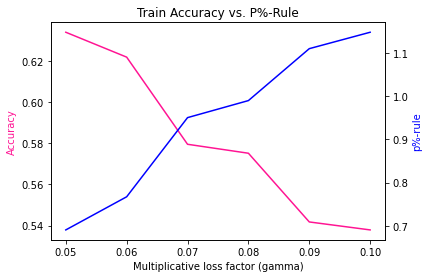

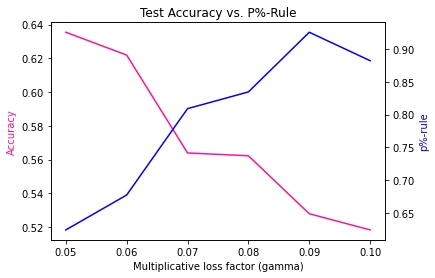

In [12]:
two_line_plot(gamma, eval_df.accuracy_train, eval_df.p_rule_value_train,
              title = 'Train Accuracy vs. P%-Rule',
              labels = ['Accuracy', 'p%-rule'])

two_line_plot(gamma, eval_df.accuracy, eval_df.p_rule_value,
              title = 'Test Accuracy vs. P%-Rule',
              labels = ['Accuracy', 'p%-rule'])

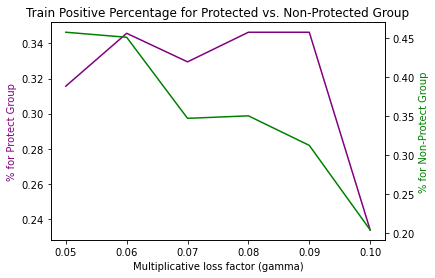

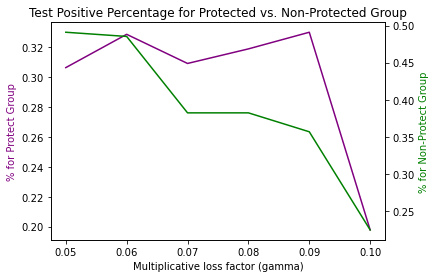

In [13]:
two_line_plot(gamma, eval_df.protected_pos_pec_train, eval_df.not_protected_pos_pec_train,
              title = 'Train Positive Percentage for Protected vs. Non-Protected Group',
              labels = ['% for Protect Group', '% for Non-Protect Group'], color = ['purple', 'green'])

two_line_plot(gamma, eval_df.protected_pos_pec, eval_df.not_protected_pos_pec,
              title = 'Test Positive Percentage for Protected vs. Non-Protected Group',
              labels = ['% for Protect Group', '% for Non-Protect Group'], color = ['purple', 'green'])
